# Configuración (Constantes)

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. DATOS DE ENTRADA (PROYECTIL 1) ---
D = 100.0      # Distancia horizontal inicial (m)
h = 20.0       # Altura inicial (m)
v = 30.0       # Velocidad inicial (m/s)
phi_deg = 10.0 # Ángulo de lanzamiento (grados)
T = 1.0        # Tiempo de retraso del Proyectil 2 (s)

# --- 2. CONSTANTES DE SIMULACIÓN ---
g = 9.81           # Gravedad
u_max = 100.0      # Velocidad máxima (m/s) - ¡Potencia alta!
C = 0.0000001      # Arrastre casi cero para validar colisión
sigma = 0.05       # Ruido
dt = 0.01          # Paso de tiempo

# Herramientas

In [26]:
# --- A. FUNCIÓN OBJETIVO ---
def F_tc(tc, D, h, v, phi_deg, T, g, u_max):
    phi_rad = np.deg2rad(phi_deg)
    den = tc - T
    if abs(den) < 1e-9: return 1e9 
    
    # Velocidad necesaria en X e Y
    ux = (D - (v * np.cos(phi_rad) * tc)) / den
    
    term2 = v * np.sin(phi_rad) * tc
    term3 = 0.5 * g * (tc**2 - den**2)
    uy = (h + term2 - term3) / den
    
    # Retornamos: Velocidad requerida^2 - Velocidad máxima^2
    return (ux**2 + uy**2) - u_max**2

# --- B. MÉTODO NUMÉRICO: BISECCIÓN ---
def metodo_biseccion(a, b, tol):
    it = 0
    f_a = F_tc(a, D, h, v, phi_deg, T, g, u_max)
    
    # Bucle de Bisección
    while (b - a) > tol:
        it += 1
        c = (a + b) / 2
        f_c = F_tc(c, D, h, v, phi_deg, T, g, u_max)
        
        # --- TU LÓGICA AQUÍ ---
        if f_a * f_c < 0:
            b = c
        else:
            a = c
            f_a = f_c
            
        if it > 100: break # Seguridad
        
    print(f"Bisección convergió en {it} iteraciones. Tiempo: {c:.4f} s")
    return c

# --- C. FÍSICA (RK4) ---
def derivadas(t, estado, C_val):
    x, y, vx, vy = estado
    v_mag = np.sqrt(vx**2 + vy**2)
    ax = -C_val * v_mag * vx
    ay = -g - (C_val * v_mag * vy)
    return np.array([vx, vy, ax, ay])

def paso_rk4(t, estado, dt, C_val):
    k1 = derivadas(t, estado, C_val)
    k2 = derivadas(t + 0.5*dt, estado + 0.5*dt*k1, C_val)
    k3 = derivadas(t + 0.5*dt, estado + 0.5*dt*k2, C_val)
    k4 = derivadas(t + dt, estado + dt*k3, C_val)
    return estado + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Ejecución Maestra

Bisección convergió en 15 iteraciones. Tiempo: 1.5658 s


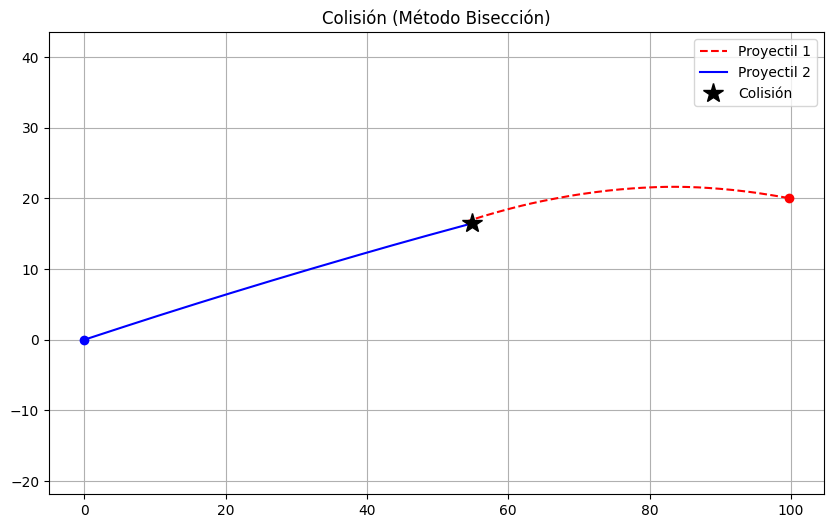

In [27]:
# 1. CALCULAR TIEMPO (Usando Bisección)
# Intervalo [1.0001, 3.0] es seguro
tc_final = metodo_biseccion(1.0001, 3.0, 0.0001)

# 2. RECALCULAR DATOS DE LANZAMIENTO P2
phi_rad = np.deg2rad(phi_deg)
den = tc_final - T
ux = (D - (v * np.cos(phi_rad) * tc_final)) / den
term2 = v * np.sin(phi_rad) * tc_final
term3 = 0.5 * g * (tc_final**2 - den**2)
uy = (h + term2 - term3) / den

u_sim = np.sqrt(ux**2 + uy**2)
theta_sim = np.arctan2(uy, ux)

# 3. SIMULACIÓN
t = 0.0
vx1 = - (v * np.cos(phi_rad)) # Velocidad negativa (Izquierda)
vy1 = v * np.sin(phi_rad)
estado_p1 = np.array([D, h, vx1, vy1])
estado_p2 = np.array([0.0, 0.0, u_sim * np.cos(theta_sim), u_sim * np.sin(theta_sim)])

hx1, hy1, hx2, hy2 = [], [], [], []

# Bucle hasta el tiempo de impacto
t_limite = tc_final + dt 

while t < t_limite:
    # P1
    estado_p1 = paso_rk4(t, estado_p1, dt, C)
    estado_p1[2] += np.random.normal(0, sigma)
    estado_p1[3] += np.random.normal(0, sigma)
    
    # P2
    if t >= T:
        estado_p2 = paso_rk4(t, estado_p2, dt, C)
        estado_p2[2] += np.random.normal(0, sigma)
        estado_p2[3] += np.random.normal(0, sigma)
    
    hx1.append(estado_p1[0]); hy1.append(estado_p1[1])
    hx2.append(estado_p2[0]); hy2.append(estado_p2[1])
    
    t += dt

# 4. GRAFICAR
plt.figure(figsize=(10, 6))
plt.plot(hx1, hy1, 'r--', label='Proyectil 1')
plt.plot(hx1[0], hy1[0], 'ro')
plt.plot(hx2, hy2, 'b-', label='Proyectil 2')
plt.plot(hx2[0], hy2[0], 'bo')
plt.plot(hx2[-1], hy2[-1], 'k*', markersize=15, label='Colisión')
plt.title(f'Colisión (Método Bisección)')
plt.grid(True); plt.legend(); plt.axis('equal')
plt.show()